<a href="https://colab.research.google.com/github/mostafa-ja/mal_adv4/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

download_links = ['https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_0.npz',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_1.npz',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_2.npz',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_y0.npz',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_y1.npz',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_y2.npz',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/model_DNN_drebin_best.pth',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/model_AT_rFGSM_weightedLoss.pth',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/model_AT_rFGSM.pth',
                  'https://github.com/mostafa-ja/mal_adv4/raw/main/dataset/insertion_array.pkl',
                  'https://github.com/mostafa-ja/mal_adv4/raw/main/dataset/removal_array.pkl',
                  'https://github.com/mostafa-ja/mal_adv4/raw/main/dataset/adverserial_attacks_functions.py'
]

In [2]:
import gdown
output_filepath = '/content/'
for link in download_links:
  gdown.download(link, output_filepath)


Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_0.npz
To: /content/sparse_matrix_0.npz
100%|██████████| 461k/461k [00:00<00:00, 6.13MB/s]
Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_1.npz
To: /content/sparse_matrix_1.npz
100%|██████████| 148k/148k [00:00<00:00, 2.88MB/s]
Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_2.npz
To: /content/sparse_matrix_2.npz
100%|██████████| 150k/150k [00:00<00:00, 2.53MB/s]
Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_y0.npz
To: /content/sparse_matrix_y0.npz
100%|██████████| 5.79k/5.79k [00:00<00:00, 10.8MB/s]
Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_y1.npz
To: /content/sparse_matrix_y1.npz
100%|██████████| 2.64k/2.64k [00:00<00:00, 7.65MB/s]
Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_y2

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,balanced_accuracy_score
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import pickle
import random
import time

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from adverserial_attacks_functions import *


torch.manual_seed(0)



cpu
cpu


In [4]:
# Open the .pkl file
with open('/content/insertion_array.pkl', 'rb') as f:
    # Load the object
    insertion_array = pickle.load(f)

# Close the file
f.close()

insertion_array = torch.tensor(insertion_array).to(device)
print(len(insertion_array))

# Open the .pkl file
with open('/content/removal_array.pkl', 'rb') as f:
    # Load the object
    removal_array = pickle.load(f)

# Close the file
f.close()

removal_array = torch.tensor(removal_array).to(device)
print(len(removal_array))


10000
10000


In [5]:

# Load dataset
X_train = sparse.load_npz("/content/sparse_matrix_0.npz").toarray()
X_val = sparse.load_npz("/content/sparse_matrix_1.npz").toarray()
X_test = sparse.load_npz("/content/sparse_matrix_2.npz").toarray()

X_train = torch.tensor(X_train, dtype=torch.int8)
X_val = torch.tensor(X_val, dtype=torch.int8)
X_test = torch.tensor(X_test, dtype=torch.int8)


y_train = sparse.load_npz("/content/sparse_matrix_y0.npz").toarray().reshape((-1, 1))
y_val = sparse.load_npz("/content/sparse_matrix_y1.npz").toarray().reshape((-1, 1))
y_test = sparse.load_npz("/content/sparse_matrix_y2.npz").toarray().reshape((-1, 1))

y_train = torch.tensor(y_train, dtype=torch.int8)
y_val = torch.tensor(y_val, dtype=torch.int8)
y_test = torch.tensor(y_test, dtype=torch.int8)


print("Shapes:")
print("x_train:", X_train.shape)
print("x_val:", X_val.shape)
print("x_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)

Shapes:
x_train: torch.Size([28683, 10000])
x_val: torch.Size([9562, 10000])
x_test: torch.Size([9562, 10000])
y_train: torch.Size([28683, 1])
y_val: torch.Size([9562, 1])
y_test: torch.Size([9562, 1])


In [6]:
# number of benigns and malicious sample in training dataset
n_ben = (y_train.squeeze()== 0).sum().item()
n_mal = (y_train.squeeze()== 1).sum().item()
print('the proportion of malwares : ', n_mal/(n_mal+n_ben))

# Combine features and labels into datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Define the DataLoader for training, validation, and test sets
batch_size = 20000
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Clear unnecessary variables
del train_dataset, val_dataset, test_dataset, y_train, y_val, y_test


the proportion of malwares :  0.11386535578565701


In [7]:
model_DNN = MalwareDetectionModel().to(device)
# Load model parameters
model_DNN.load_state_dict(torch.load('model_DNN_drebin_best.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [8]:
# Create an instance of your model
model_AT_rFGSM = MalwareDetectionModel().to(device)

# Load model parameters
model_AT_rFGSM.load_state_dict(torch.load('model_AT_rFGSM.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [9]:
# Create an instance of your model
model_AT_rFGSM_weightedLoss = MalwareDetectionModel().to(device)

# Load model parameters
model_AT_rFGSM_weightedLoss.load_state_dict(torch.load('model_AT_rFGSM_weightedLoss.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [10]:
for x,y in test_loader:
  print(x.shape)
  break

bens = x[y.squeeze()==0]
mals = x[y.squeeze()==1]
print(bens.shape)
print(mals.shape)

torch.Size([9562, 10000])
torch.Size([8432, 10000])
torch.Size([1130, 10000])


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
kmeans = KMeans(n_clusters=500, init='k-means++', n_init='auto')
cluster_labels = kmeans.fit_predict(bens)
print(kmeans.inertia_)
#silhouette_avg = silhouette_score(bens, cluster_labels)
#print(silhouette_avg)


23832.401241587977


In [ ]:
cluster_centers = torch.tensor(kmeans.cluster_centers_)
cluster_centers.shape

torch.Size([500, 10000])

In [ ]:
kmeans.labels_

array([ 26,  72,  62, ...,  49, 305,  62], dtype=int32)

In [ ]:
# Count the number of samples in each cluster
cluster_counts = torch.tensor(np.bincount(cluster_labels))

# Print the number of samples in each cluster
#for cluster_id, count in enumerate(cluster_counts):
   # print(f"Cluster {cluster_id}: {count} samples")

In [ ]:
print(cluster_counts.shape)
print(cluster_counts)

torch.Size([500])
tensor([  1,   6,  54,  25, 442,  26,   2,   3,  41,  21,   9,   7, 138,  14,
         67,   2, 149,  12,   2, 212,  11, 105,  13,  82,   2,  78,  35,   8,
          3,  11,  13,   3,   7,   2,   4,  25,  14,  16,   9,  13,   5,  16,
          6,   2,  19,  28, 148,  67,   3, 110,  31,   7,   2,   5,   8,  19,
         19,   3,   8,   6,  31,   2, 667,  25,  31,   8,  24,   1,  55,  39,
          1,   6,  28,   8,  65,   4,   5,  12,   2,   7,  27,  14,   8,   4,
         64,   7,   3,   6,   1,   8,   7,   5,  15,   4,  26,  18,  17,   3,
         21,  18,  13,  10,   9,  11,   2,  17,   9,   3,   3,  13,  24,  21,
          1,  15,   1,   5,   3,  12,  10,  10,  98,   3,   2,   4,  49,  25,
          4,  13,   3,  14,  31,   2,   4,  23,  21,  38,   4,  44,   9,   1,
          7,  12,   6,  17,  21,   1,   8,   1,   6,   6,  22,  14,  29,   6,
          1,   2,   3,  10,  92,   5,   6,  15,   9,   3,  24,   3,   7,   4,
          6,  19,   5,   3,   2,   2,  42,   5

In [ ]:
cluster_counts.sum()

tensor(8432)

In [40]:
import torch

# Define the multivariate Gaussian kernel function
def gaussian_kernel(u):
    """
    Compute the value of the Gaussian kernel function at point u.

    Parameters:
        u (torch.Tensor): Standardized distance between data points and evaluation points.

    Returns:
        torch.Tensor: Array of Gaussian kernel values.
    """
    d = u.shape[1]  # Number of dimensions (features) of the data
    # normalization constant for the Gaussian kernel in d dimensions
    #normalization = (2 * np.pi) ** (-d / 2)
    normalization = 10.  # normalization constant for the Gaussian kernel in d dimensions
    return normalization * torch.exp(-0.5 * torch.sum(u**2, dim=-1))

# Multidimensional KDE implementation
def KDE(x, data, cluster_counts, bandwidth):
    """
    Compute the kernel density estimate (KDE) for given data points.

    Parameters:
        x (torch.Tensor): Points at which to evaluate the KDE (shape: [num_samples, num_dimensions]).
        data (torch.Tensor): Data points used to estimate the density (shape: [num_data_points, num_dimensions]).
        bandwidth (float): Bandwidth parameter for the KDE.

    Returns:
        torch.Tensor: Density estimate at each point in x (shape: [num_samples,]).
    """
    n = data.shape[0]  # Number of data points
    d = x.shape[1]  # Dimensionality of the data

    # Convert bandwidth to tensor
    bandwidth_tensor = torch.tensor(bandwidth)

    # Calculate standardized distances for all data points
    u = (x[:, None, :] - data) / bandwidth_tensor
    #print(u.shape)
    # Compute Gaussian kernel contributions for all data points
    kernel_contributions = gaussian_kernel(u)
    #print(kernel_contributions.shape)
    # Sum contributions across all data points
    #kernel_contributions = torch.ones((40, 100))
    #print((kernel_contributions).sum())
    #print((kernel_contributions* cluster_counts[np.newaxis,:]).sum()*cluster_counts.shape/cluster_counts.sum())
    #estimate = torch.mean((kernel_contributions* cluster_counts[np.newaxis,:]), dim=1) * cluster_counts.shape[0] / cluster_counts.sum()
    estimate = torch.mean((kernel_contributions), dim=1)
    print(estimate.sum())
    # Normalize the density estimate by the number of points and the bandwidth raised to the dimensionality
    #estimate /= (bandwidth_tensor ** d)

    return estimate


def KDE_wheighted(x, data, cluster_counts, bandwidth):
    """
    Compute the kernel density estimate (KDE) for given data points.

    Parameters:
        x (torch.Tensor): Points at which to evaluate the KDE (shape: [num_samples, num_dimensions]).
        data (torch.Tensor): Data points used to estimate the density (shape: [num_data_points, num_dimensions]).
        bandwidth (float): Bandwidth parameter for the KDE.

    Returns:
        torch.Tensor: Density estimate at each point in x (shape: [num_samples,]).
    """
    n = data.shape[0]  # Number of data points
    d = x.shape[1]  # Dimensionality of the data

    # Convert bandwidth to tensor
    bandwidth_tensor = torch.tensor(bandwidth)

    # Calculate standardized distances for all data points
    u = (x[:, None, :] - data) / bandwidth_tensor

    # Compute Gaussian kernel contributions for all data points
    kernel_contributions = gaussian_kernel(u)
    estimate = torch.mean((kernel_contributions* cluster_counts[np.newaxis,:]), dim=1) * cluster_counts.shape[0] / cluster_counts.sum()
    print(estimate.sum())


    return estimate

In [ ]:
cluster_counts.shape

500

In [ ]:
KDE(mals[:50], cluster_centers,cluster_counts, 0.6)

torch.Size([50, 500, 10000])
torch.Size([50, 500])
tensor(0.0025, dtype=torch.float64)


tensor([2.6110e-06, 2.8833e-10, 2.1197e-13, 5.6274e-56, 2.8833e-10, 1.3879e-13,
        1.2672e-21, 6.0924e-07, 3.8077e-30, 3.2664e-25, 2.6110e-06, 5.9691e-07,
        2.8833e-10, 2.4705e-07, 1.0950e-12, 1.0513e-10, 5.9764e-27, 5.9982e-35,
        1.2897e-13, 2.7868e-29, 4.3431e-23, 1.2853e-08, 2.8833e-10, 4.4694e-31,
        2.2105e-14, 4.4934e-11, 1.5229e-07, 1.0513e-10, 7.6714e-04, 1.8822e-12,
        8.0316e-19, 4.8599e-35, 2.8833e-10, 2.6304e-09, 1.4073e-26, 4.8253e-10,
        1.1550e-14, 1.9757e-06, 1.3699e-29, 1.7428e-03, 2.4743e-11, 1.7019e-15,
        3.7726e-10, 1.0349e-12, 1.7590e-17, 3.2535e-06, 3.7244e-20, 6.0682e-08,
        1.3862e-05, 5.9854e-12], dtype=torch.float64)

In [ ]:
KDE(mals[:50], cluster_centers,cluster_counts, 0.6)

torch.Size([50, 500, 10000])
torch.Size([50, 500])
tensor(0.0178, dtype=torch.float64)


tensor([1.9920e-05, 1.3438e-09, 3.8529e-13, 4.6536e-56, 1.3438e-09, 1.8095e-13,
        2.0085e-21, 3.3488e-06, 3.2943e-30, 6.1238e-26, 1.9920e-05, 7.0555e-07,
        1.3438e-09, 8.6729e-07, 5.3709e-13, 2.8893e-10, 1.5200e-27, 3.1114e-35,
        1.1374e-13, 1.6336e-29, 3.7699e-23, 9.6681e-09, 1.3438e-09, 2.7539e-31,
        2.8087e-14, 3.7736e-11, 8.4412e-07, 2.8893e-10, 7.3082e-03, 1.2083e-12,
        1.9522e-19, 4.0324e-35, 1.3438e-09, 2.8626e-09, 8.6200e-27, 1.8375e-09,
        2.1605e-14, 2.0308e-06, 1.4576e-29, 1.0381e-02, 2.1911e-11, 1.4073e-15,
        1.0169e-09, 9.4188e-13, 2.9757e-17, 2.2085e-05, 6.6452e-21, 6.1074e-08,
        4.3765e-05, 4.5151e-12], dtype=torch.float64)

In [ ]:
KDE(bens[:50], cluster_centers,cluster_counts, 0.6)

torch.Size([50, 500, 10000])
torch.Size([50, 500])
tensor(0.5953, dtype=torch.float64)


tensor([2.0000e-02, 3.1384e-03, 8.0637e-02, 2.6987e-02, 1.0592e-05, 5.3637e-07,
        7.5186e-07, 4.1922e-03, 9.1330e-04, 8.9659e-03, 4.5846e-03, 2.6640e-05,
        2.3496e-02, 2.0000e-02, 1.8593e-02, 8.0637e-02, 2.0885e-05, 9.3961e-06,
        7.2347e-04, 8.0637e-02, 4.9422e-03, 7.7331e-03, 1.9172e-05, 6.5266e-05,
        2.5138e-03, 6.1728e-04, 6.5843e-03, 1.2062e-02, 1.0330e-04, 5.1513e-03,
        1.2095e-03, 2.0887e-06, 2.0000e-02, 7.6220e-06, 4.1981e-03, 3.3648e-04,
        1.0341e-03, 4.9870e-03, 1.0930e-04, 2.4010e-02, 3.1414e-04, 2.5658e-02,
        4.7249e-02, 1.0352e-02, 6.0776e-03, 1.9769e-04, 1.4680e-02, 2.0001e-02,
        4.7870e-04, 9.9573e-04], dtype=torch.float64)

In [ ]:
KDE(bens[:50], cluster_centers,cluster_counts, 0.6)

torch.Size([50, 500, 10000])
torch.Size([50, 500])
tensor(5.5837, dtype=torch.float64)


tensor([4.1509e-02, 9.0092e-03, 1.1556e+00, 2.4985e-01, 6.0547e-05, 1.1299e-06,
        2.9933e-06, 2.9831e-03, 1.6247e-04, 8.5033e-02, 3.7719e-02, 1.2134e-04,
        3.3069e-01, 1.5418e-02, 1.3413e-02, 1.1556e+00, 3.7987e-05, 2.1158e-05,
        1.5813e-03, 1.1556e+00, 2.8784e-02, 7.6380e-02, 1.4066e-04, 1.7125e-04,
        9.6061e-03, 1.3283e-03, 1.9548e-03, 1.0517e-01, 4.5161e-04, 7.4111e-02,
        5.1074e-03, 1.8333e-05, 1.5418e-02, 4.6396e-06, 3.1082e-02, 1.9638e-03,
        2.0574e-03, 5.9145e-04, 2.8683e-04, 2.4939e-01, 2.6083e-03, 1.8421e-01,
        4.5508e-01, 4.0369e-02, 2.4788e-02, 1.2100e-03, 1.3928e-02, 2.3763e-03,
        2.8613e-04, 4.2689e-04], dtype=torch.float64)

# **Just non_removable features**

In [12]:
removal_array.sum()

tensor(8856., dtype=torch.float64)

In [30]:
non_removal_array = torch.tensor((1 - removal_array), dtype=torch.bool)
non_removal_array.sum()

<ipython-input-30-0a980a23af93>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  non_removal_array = torch.tensor((1 - removal_array), dtype=torch.bool)


tensor(1144)

In [31]:
non_removal_array

tensor([ True,  True,  True,  ..., False, False, False])

In [36]:
x2 = x[:,non_removal_array]
print(x2.shape)

bens2 = x2[y.squeeze()==0]
mals2 = x2[y.squeeze()==1]
print(bens2.shape)
print(mals2.shape)

torch.Size([9562, 1144])
torch.Size([8432, 1144])
torch.Size([1130, 1144])


In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
kmeans = KMeans(n_clusters=500, init='k-means++', n_init='auto')
cluster_labels = kmeans.fit_predict(bens2)
print(kmeans.inertia_)
#silhouette_avg = silhouette_score(bens, cluster_labels)
#print(silhouette_avg)


7249.709246196629


In [38]:
cluster_centers = torch.tensor(kmeans.cluster_centers_)
cluster_centers.shape

torch.Size([500, 1144])

In [39]:
# Count the number of samples in each cluster
cluster_counts = torch.tensor(np.bincount(cluster_labels))

print(cluster_counts.shape)
print(cluster_counts)

torch.Size([500])
tensor([ 71,  38,  91, 660,  65,  31,  87,   9, 899,  25,  80, 212,   5,  31,
         11,  21,  20,   1,   3,  13,  13,  14, 170,  43,  18,  18, 169,  16,
         12,  19,   1,   3,   1, 174,  67,  49,  15,  49,  71,  22,   2,   5,
         11,  34,  17,   1,  75,  43,   4,  47,   2,  53,   2, 116,  25,  54,
         46,  24,  12,   1,  10,  35,  16,  32,  27,   9, 156,  12,   9,  86,
         84,  65,   6,   3,   8,   1,  12,  47,   1,  42,   4,  29,  37,  42,
          2,   1,   2,   9,   7,  14,  35,   3,  18,   1,   4,  22,  20,  12,
         15,  31,  22,   1,  28,  17,   9,  14,  30,  31,  17,  19,  16,   7,
          8,   6,  51,   4,  33,  11,   8,  28,  31,  11,  14,  17,   1,   1,
         16,  75,   1,  13,   1,   4,   2,  10,   1,   3,  20,  20,  13,  13,
         17,   2,   3,   3,  46,   2,   1,   3,  13,  14,  14,   2,   4,  82,
          1,   8,   1,   4,   1,   2,  11,  42,   1,   1,  15,   8,   9,   2,
         11,  67,  19,  13,   3,  28,   1,  31

In [41]:
KDE(mals2[:50], cluster_centers,cluster_counts, 0.6)

tensor(0.1184, dtype=torch.float64)


tensor([2.2247e-02, 1.4080e-03, 2.4407e-06, 1.6650e-16, 1.4080e-03, 3.3392e-06,
        5.4930e-12, 4.8931e-05, 4.6633e-15, 1.0436e-07, 2.2247e-02, 7.0210e-03,
        1.4080e-03, 5.2646e-04, 8.7806e-08, 3.9356e-05, 1.5242e-08, 4.5163e-12,
        3.0542e-06, 4.2779e-14, 7.2371e-12, 6.0344e-04, 1.4080e-03, 4.1247e-16,
        5.2090e-08, 5.4043e-04, 3.5661e-03, 3.9356e-05, 2.4214e-02, 8.2116e-07,
        3.4113e-08, 1.0928e-22, 1.4080e-03, 2.5940e-05, 7.2840e-13, 5.2843e-05,
        1.8487e-05, 8.8449e-05, 1.2148e-15, 2.3167e-02, 1.7331e-06, 4.7669e-11,
        3.0296e-06, 9.3224e-06, 1.0661e-06, 1.1078e-03, 7.9908e-09, 3.0631e-04,
        5.4328e-03, 1.5817e-09], dtype=torch.float64)

In [42]:
KDE(bens2[:50], cluster_centers,cluster_counts, 0.6)

tensor(2.4714, dtype=torch.float64)


tensor([0.0545, 0.0862, 0.1255, 0.0767, 0.0173, 0.0011, 0.0029, 0.0125, 0.0110,
        0.0767, 0.0669, 0.0027, 0.0757, 0.0333, 0.0612, 0.1255, 0.0049, 0.0321,
        0.0157, 0.1255, 0.0350, 0.1437, 0.0859, 0.0446, 0.0497, 0.0225, 0.1437,
        0.0347, 0.0143, 0.1255, 0.0243, 0.0116, 0.0333, 0.0209, 0.0197, 0.0364,
        0.0621, 0.0071, 0.0014, 0.1437, 0.0051, 0.0567, 0.0871, 0.0620, 0.1255,
        0.0015, 0.0184, 0.0200, 0.0118, 0.0150], dtype=torch.float64)

In [43]:
KDE_wheighted(mals2[:50], cluster_centers,cluster_counts, 0.6)

tensor(0.5519, dtype=torch.float64)


tensor([1.1565e-01, 4.6790e-03, 2.8256e-06, 9.6676e-17, 4.6790e-03, 4.4206e-06,
        2.7316e-12, 9.7146e-05, 2.9692e-15, 6.4968e-08, 1.1565e-01, 1.0879e-02,
        4.6790e-03, 1.0009e-03, 1.0328e-07, 3.0979e-05, 7.2015e-09, 2.8012e-13,
        2.6632e-06, 1.5800e-14, 8.0079e-12, 8.1821e-04, 4.6790e-03, 1.1408e-16,
        9.7740e-08, 5.8770e-04, 1.1720e-02, 3.0979e-05, 1.7303e-01, 4.9171e-07,
        2.4713e-08, 2.5092e-23, 4.6790e-03, 1.5310e-05, 2.6463e-13, 9.7511e-05,
        2.2287e-05, 1.0165e-04, 6.8684e-16, 7.8309e-02, 1.7312e-06, 2.0587e-11,
        2.4490e-06, 9.8652e-06, 9.9257e-07, 6.4160e-03, 5.7945e-09, 3.4603e-04,
        1.3652e-02, 9.1271e-10], dtype=torch.float64)

In [44]:
KDE_wheighted(bens2[:50], cluster_centers,cluster_counts, 0.6)

tensor(17.9456, dtype=torch.float64)


tensor([1.7148e-01, 5.0331e-01, 1.5836e+00, 3.6562e-01, 5.9040e-02, 3.2161e-03,
        6.5679e-03, 1.0343e-02, 2.2527e-03, 3.6562e-01, 2.0160e-01, 5.2525e-03,
        5.0527e-01, 5.2134e-02, 1.5565e-01, 1.5836e+00, 1.6283e-02, 9.9013e-02,
        4.5825e-02, 1.5836e+00, 1.3487e-01, 1.4393e+00, 4.8053e-01, 9.3614e-02,
        1.3335e-01, 6.0191e-02, 1.4393e+00, 1.9198e-01, 4.3932e-02, 1.5836e+00,
        5.6048e-02, 1.0393e-02, 5.2134e-02, 1.2796e-02, 5.6342e-02, 3.6286e-01,
        1.5990e-01, 8.3863e-04, 1.4422e-03, 1.4393e+00, 3.2110e-02, 2.7861e-01,
        6.7722e-01, 2.3088e-01, 1.5836e+00, 5.9355e-03, 1.7619e-02, 2.4397e-03,
        1.7860e-02, 2.7308e-02], dtype=torch.float64)

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming 'high_dim_data' is your high-dimensional dataset, stored in a numpy array or pandas DataFrame
# Example: high_dim_data = ...

# Define the parameter grid
eps_values = [3.1]      # Adjust range and step size as needed
min_samples_values = range(2, 61)              # Adjust range as needed

best_params = None
best_score = -1

# Iterate over parameter combinations
for eps in eps_values:
    for min_samples in min_samples_values:


        print('*******************************')
        print('eps,min_samples : ',eps,min_samples)

        # Compute silhouette score
        #silhouette_avg = silhouette_score(bens, cluster_labels)
        #print('silhouette_avg',silhouette_avg)

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit DBSCAN model to the data
        cluster_labels = dbscan.fit_predict(x)
        n_clusters_ = len(set(dbscan.labels_))
        print('n_clusters_ : ', n_clusters_)

        outliers_mask = (dbscan.labels_ == -1)

        print('number of outliers : ',outliers_mask.sum())
        print('number of malwares in outliers : ',y[outliers_mask].sum())

        for i in range(10):
          print('cluster : ',i)
          mask = dbscan.labels_ == i
          print('number of samples in cluster : ',mask.sum())
          print('number of malwares in cluster : ',y[mask].sum())

*******************************
eps,min_samples :  3.1 2
n_clusters_ :  243
number of outliers :  872
number of malwares in outliers :  tensor(222)
cluster :  0
number of samples in cluster :  35
number of malwares in cluster :  tensor(0)
cluster :  1
number of samples in cluster :  7307
number of malwares in cluster :  tensor(212)
cluster :  2
number of samples in cluster :  11
number of malwares in cluster :  tensor(0)
cluster :  3
number of samples in cluster :  38
number of malwares in cluster :  tensor(38)
cluster :  4
number of samples in cluster :  3
number of malwares in cluster :  tensor(0)
cluster :  5
number of samples in cluster :  12
number of malwares in cluster :  tensor(12)
cluster :  6
number of samples in cluster :  21
number of malwares in cluster :  tensor(0)
cluster :  7
number of samples in cluster :  2
number of malwares in cluster :  tensor(0)
cluster :  8
number of samples in cluster :  28
number of malwares in cluster :  tensor(28)
cluster :  9
number of sampl

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming 'high_dim_data' is your high-dimensional dataset, stored in a numpy array or pandas DataFrame
# Example: high_dim_data = ...

# Define the parameter grid
eps_values = [4.1]      # Adjust range and step size as needed
min_samples_values = range(40, 61)              # Adjust range as needed

best_params = None
best_score = -1

# Iterate over parameter combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        # Initialize DBSCAN model with current parameter combination
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit DBSCAN model to the data
        cluster_labels = dbscan.fit_predict(bens)

        outliers_mask = (dbscan.labels_ == -1)
        print('eps,min_samples : ',eps,min_samples)
        n_clusters_ = len(set(dbscan.labels_))
        print('n_clusters_ : ', n_clusters_)
        print('number of outliers : ',(outliers_mask).sum())
        # Compute silhouette score
        #silhouette_avg = silhouette_score(bens, cluster_labels)
        #print('silhouette_avg',silhouette_avg)



eps,min_samples :  4.1 40
n_clusters_ :  2
number of outliers :  456
eps,min_samples :  4.1 41
n_clusters_ :  2
number of outliers :  456
eps,min_samples :  4.1 42
n_clusters_ :  2
number of outliers :  456
eps,min_samples :  4.1 43
n_clusters_ :  2
number of outliers :  456
eps,min_samples :  4.1 44
n_clusters_ :  2
number of outliers :  456
eps,min_samples :  4.1 45
n_clusters_ :  2
number of outliers :  456
eps,min_samples :  4.1 46
n_clusters_ :  2
number of outliers :  456
eps,min_samples :  4.1 47
n_clusters_ :  2
number of outliers :  456
eps,min_samples :  4.1 48
n_clusters_ :  2
number of outliers :  456
eps,min_samples :  4.1 49
n_clusters_ :  2
number of outliers :  456
eps,min_samples :  4.1 50
n_clusters_ :  2
number of outliers :  456
eps,min_samples :  4.1 51
n_clusters_ :  2
number of outliers :  457
eps,min_samples :  4.1 52
n_clusters_ :  2
number of outliers :  457
eps,min_samples :  4.1 53
n_clusters_ :  2
number of outliers :  459
eps,min_samples :  4.1 54
n_cluste

KeyboardInterrupt: 

In [ ]:
eps = 4.1
min_samples = 53

# Initialize DBSCAN model with current parameter combination
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit DBSCAN model to the data
cluster_labels = dbscan.fit_predict(x)

outliers_mask = (dbscan.labels_ == -1)
print('eps,min_samples : ',eps,min_samples)
n_clusters_ = len(set(dbscan.labels_))
print('n_clusters_ : ', n_clusters_)
print('number of outliers : ',(outliers_mask).sum())


eps,min_samples :  4.1 53
n_clusters_ :  2
number of outliers :  1090


In [ ]:
# Identify outliers (data points with label -1)
mask = dbscan.labels_ == 0
print(mask.sum())
print(y[mask].sum())

8472
tensor(495)


In [ ]:
len(bens)

8432

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming 'high_dim_data' is your high-dimensional dataset, stored in a numpy array or pandas DataFrame
# Example: high_dim_data = ...

# Define the parameter grid
eps_values = [4.1]      # Adjust range and step size as needed
min_samples_values = range(5, 61)              # Adjust range as needed

best_params = None
best_score = -1

# Iterate over parameter combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        # Initialize DBSCAN model with current parameter combination
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit DBSCAN model to the data
        cluster_labels = dbscan.fit_predict(bens)

        outliers_mask = (dbscan.labels_ == -1)
        print('*******************************')
        print('eps,min_samples : ',eps,min_samples)
        n_clusters_ = len(set(dbscan.labels_))
        print('n_clusters_ : ', n_clusters_)
        print('number of outliers : ',(outliers_mask).sum())
        # Compute silhouette score
        #silhouette_avg = silhouette_score(bens, cluster_labels)
        #print('silhouette_avg',silhouette_avg)

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit DBSCAN model to the data
        cluster_labels = dbscan.fit_predict(x)

        # Identify number of benigns (data points with label -1)
        mask = dbscan.labels_ == 0
        print(mask.sum())
        print(y[mask].sum())



*******************************
eps,min_samples :  4.1 5
n_clusters_ :  17
number of outliers :  279
8729
tensor(715)
*******************************
eps,min_samples :  4.1 6
n_clusters_ :  13
number of outliers :  305
8720
tensor(707)
*******************************
eps,min_samples :  4.1 7
n_clusters_ :  10
number of outliers :  324
8647
tensor(636)
*******************************
eps,min_samples :  4.1 8
n_clusters_ :  7
number of outliers :  350
8645
tensor(634)
*******************************
eps,min_samples :  4.1 9
n_clusters_ :  7
number of outliers :  361
8640
tensor(634)
*******************************
eps,min_samples :  4.1 10
n_clusters_ :  5
number of outliers :  379
8632
tensor(627)
*******************************
eps,min_samples :  4.1 11
n_clusters_ :  5
number of outliers :  380
8622
tensor(624)
*******************************
eps,min_samples :  4.1 12
n_clusters_ :  5
number of outliers :  380
8622
tensor(624)
*******************************
eps,min_samples :  4.1 13


KeyboardInterrupt: 

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming 'high_dim_data' is your high-dimensional dataset, stored in a numpy array or pandas DataFrame
# Example: high_dim_data = ...

# Define the parameter grid
eps_values = [3.1]      # Adjust range and step size as needed
min_samples_values = range(2, 61)              # Adjust range as needed

best_params = None
best_score = -1

# Iterate over parameter combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        # Initialize DBSCAN model with current parameter combination
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit DBSCAN model to the data
        cluster_labels = dbscan.fit_predict(bens)

        outliers_mask = (dbscan.labels_ == -1)
        print('*******************************')
        print('eps,min_samples : ',eps,min_samples)
        n_clusters_ = len(set(dbscan.labels_))
        print('n_clusters_ : ', n_clusters_)
        print('number of outliers : ',(outliers_mask).sum())
        # Compute silhouette score
        #silhouette_avg = silhouette_score(bens, cluster_labels)
        #print('silhouette_avg',silhouette_avg)

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit DBSCAN model to the data
        cluster_labels = dbscan.fit_predict(x)

        # Identify number of benigns (data points with label -1)
        mask = dbscan.labels_ == 0
        print(mask.sum())
        print(y[mask].sum())

*******************************
eps,min_samples :  3.1 2
n_clusters_ :  131
number of outliers :  653
35
tensor(0)
*******************************
eps,min_samples :  3.1 3
n_clusters_ :  73
number of outliers :  769
35
tensor(0)
*******************************
eps,min_samples :  3.1 4
n_clusters_ :  50
number of outliers :  845
35
tensor(0)
*******************************
eps,min_samples :  3.1 5
n_clusters_ :  36
number of outliers :  904
35
tensor(0)
*******************************
eps,min_samples :  3.1 6
n_clusters_ :  25
number of outliers :  962
35
tensor(0)
*******************************
eps,min_samples :  3.1 7
n_clusters_ :  24
number of outliers :  972
35
tensor(0)
*******************************
eps,min_samples :  3.1 8
n_clusters_ :  20
number of outliers :  1003
35
tensor(0)
*******************************
eps,min_samples :  3.1 9
n_clusters_ :  18
number of outliers :  1021
35
tensor(0)
*******************************
eps,min_samples :  3.1 10
n_clusters_ :  15
number of

In [ ]:
eps = 3.1
min_samples = 36

# Initialize DBSCAN model with current parameter combination
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit DBSCAN model to the data
cluster_labels = dbscan.fit_predict(x)



In [ ]:
mask = dbscan.labels_ == -1
print(mask.sum())
print(y[mask].sum())

2164
tensor(849)


In [ ]:
mask = dbscan.labels_ == 0
print(mask.sum())
print(y[mask].sum())

7182
tensor(190)


In [ ]:
mask = dbscan.labels_ == 1
print(mask.sum())
print(y[mask].sum())

38
tensor(38)


In [ ]:
mask = dbscan.labels_ == 2
print(mask.sum())
print(y[mask].sum())

52
tensor(0)


In [ ]:
mask = dbscan.labels_ == 3
print(mask.sum())
print(y[mask].sum())

53
tensor(53)


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming 'high_dim_data' is your high-dimensional dataset, stored in a numpy array or pandas DataFrame
# Example: high_dim_data = ...

# Define the parameter grid
eps_values = [4.1]      # Adjust range and step size as needed
min_samples_values = range(2, 61)              # Adjust range as needed

best_params = None
best_score = -1

# Iterate over parameter combinations
for eps in eps_values:
    for min_samples in min_samples_values:


        print('*******************************')
        print('eps,min_samples : ',eps,min_samples)


        print('number of outliers : ',(outliers_mask).sum())
        # Compute silhouette score
        #silhouette_avg = silhouette_score(bens, cluster_labels)
        #print('silhouette_avg',silhouette_avg)

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit DBSCAN model to the data
        cluster_labels = dbscan.fit_predict(x)
        n_clusters_ = len(set(dbscan.labels_))
        print('n_clusters_ : ', n_clusters_)

        outliers_mask = (dbscan.labels_ == -1)

        print('number of outliers : ',outliers_mask.sum())
        print('number of malwares in outliers : ',y[outliers_mask].sum())

        for i in range(10):
          print('cluster : ',i)
          mask = dbscan.labels_ == i
          print('number of samples in cluster : ',mask.sum())
          print('number of malwares in cluster : ',y[mask].sum())

*******************************
eps,min_samples :  4.1 2
n_clusters_ :  51
number of outliers :  188
cluster :  0
number of samples in cluster :  8745
number of malwares in cluster :  tensor(728)
cluster :  1
number of samples in cluster :  12
number of malwares in cluster :  tensor(0)
cluster :  2
number of samples in cluster :  3
number of malwares in cluster :  tensor(0)
cluster :  3
number of samples in cluster :  16
number of malwares in cluster :  tensor(0)
cluster :  4
number of samples in cluster :  7
number of malwares in cluster :  tensor(7)
cluster :  5
number of samples in cluster :  5
number of malwares in cluster :  tensor(0)
cluster :  6
number of samples in cluster :  4
number of malwares in cluster :  tensor(0)
cluster :  7
number of samples in cluster :  7
number of malwares in cluster :  tensor(0)
cluster :  8
number of samples in cluster :  2
number of malwares in cluster :  tensor(0)
cluster :  9
number of samples in cluster :  2
number of malwares in cluster :  te

KeyboardInterrupt: 

In [ ]:
eps = 4.1
min_samples = 30

# Initialize DBSCAN model with current parameter combination
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit DBSCAN model to the data
cluster_labels = dbscan.fit_predict(x)

outliers_mask = (dbscan.labels_ == -1)
print('eps,min_samples : ',eps,min_samples)
n_clusters_ = len(set(dbscan.labels_))
print('n_clusters_ : ', n_clusters_)
print('number of outliers : ',(outliers_mask).sum())


eps,min_samples :  4.1 30
n_clusters_ :  5
number of outliers :  871


In [ ]:
# Identify number of benigns (data points with label -1)
mask = dbscan.labels_ == 0
print(mask.sum())
print(y[mask].sum())

8581
tensor(603)


In [ ]:
# Identify outliers (data points with label -1)
mask = dbscan.labels_ == 1
print(mask.sum())
print(y[mask].sum())

36
tensor(36)


In [ ]:
len(bens)

8432

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming 'high_dim_data' is your high-dimensional dataset, stored in a numpy array or pandas DataFrame
# Example: high_dim_data = ...

# Define the parameter grid
eps_values = np.linspace(1.1, 10, 10)      # Adjust range and step size as needed
min_samples_values = range(2, 10)              # Adjust range as needed

best_params = None
best_score = -1

# Iterate over parameter combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        # Initialize DBSCAN model with current parameter combination
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit DBSCAN model to the data
        cluster_labels = dbscan.fit_predict(bens)

        outliers_mask = (dbscan.labels_ == -1)
        print('eps,min_samples : ',eps,min_samples)
        n_clusters_ = len(set(dbscan.labels_))
        print('n_clusters_ : ', n_clusters_)
        print('number of outliers : ',(outliers_mask).sum())
        # Compute silhouette score
        silhouette_avg = silhouette_score(bens, cluster_labels)
        print('silhouette_avg',silhouette_avg)

        # Update best parameters and score if current combination is better
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_params = {'eps': eps, 'min_samples': min_samples}

# Print the best parameters and score
print("Best parameters:", best_params)
print("Best silhouette score:", best_score)


eps,min_samples :  1.1 2
n_clusters_ :  432
number of outliers :  3682
silhouette_avg 0.0022268438847278605
eps,min_samples :  1.1 3
n_clusters_ :  194
number of outliers :  4158
silhouette_avg -0.03334787454859125
eps,min_samples :  1.1 4
n_clusters_ :  123
number of outliers :  4388
silhouette_avg -0.04047552929970615
eps,min_samples :  1.1 5
n_clusters_ :  91
number of outliers :  4540
silhouette_avg -0.04387369773647142
eps,min_samples :  1.1 6
n_clusters_ :  64
number of outliers :  4699
silhouette_avg -0.05057731008598914
eps,min_samples :  1.1 7
n_clusters_ :  55
number of outliers :  4781
silhouette_avg -0.05402261063280433
eps,min_samples :  1.1 8
n_clusters_ :  50
number of outliers :  4848
silhouette_avg -0.06008944358415181
eps,min_samples :  1.1 9
n_clusters_ :  42
number of outliers :  4936
silhouette_avg -0.06296980664035401
eps,min_samples :  2.088888888888889 2
n_clusters_ :  275
number of outliers :  1846
silhouette_avg 0.008925074948999502
eps,min_samples :  2.088888

KeyboardInterrupt: 

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming 'high_dim_data' is your high-dimensional dataset, stored in a numpy array or pandas DataFrame
# Example: high_dim_data = ...

# Define the parameter grid
eps_values = np.linspace(4.1, 8.1, 4)      # Adjust range and step size as needed
min_samples_values = range(10, 16)              # Adjust range as needed

best_params = None
best_score = -1

# Iterate over parameter combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        # Initialize DBSCAN model with current parameter combination
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit DBSCAN model to the data
        cluster_labels = dbscan.fit_predict(bens)

        outliers_mask = (dbscan.labels_ == -1)
        print('eps,min_samples : ',eps,min_samples)
        n_clusters_ = len(set(dbscan.labels_))
        print('n_clusters_ : ', n_clusters_)
        print('number of outliers : ',(outliers_mask).sum())
        # Compute silhouette score
        silhouette_avg = silhouette_score(bens, cluster_labels)
        print('silhouette_avg',silhouette_avg)

        # Update best parameters and score if current combination is better
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_params = {'eps': eps, 'min_samples': min_samples}

# Print the best parameters and score
print("Best parameters:", best_params)
print("Best silhouette score:", best_score)


eps,min_samples :  4.1 10
n_clusters_ :  5
number of outliers :  379
silhouette_avg 0.2575558296899581
eps,min_samples :  4.1 11
n_clusters_ :  5
number of outliers :  380
silhouette_avg 0.2575556435517074
eps,min_samples :  4.1 12
n_clusters_ :  5
number of outliers :  380
silhouette_avg 0.2575556435517074
eps,min_samples :  4.1 13
n_clusters_ :  4
number of outliers :  395
silhouette_avg 0.25598811538725424
eps,min_samples :  4.1 14
n_clusters_ :  4
number of outliers :  397
silhouette_avg 0.25600819083745346
eps,min_samples :  4.1 15
n_clusters_ :  4
number of outliers :  399
silhouette_avg 0.2560144777028913
eps,min_samples :  5.433333333333333 10
n_clusters_ :  3
number of outliers :  95
silhouette_avg 0.4535991961528563
eps,min_samples :  5.433333333333333 11
n_clusters_ :  3
number of outliers :  96
silhouette_avg 0.45307585442340476
eps,min_samples :  5.433333333333333 12
n_clusters_ :  3
number of outliers :  96
silhouette_avg 0.45307585442340476
eps,min_samples :  5.433333333

KeyboardInterrupt: 

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming 'high_dim_data' is your high-dimensional dataset, stored in a numpy array or pandas DataFrame
# Example: high_dim_data = ...

# Define the parameter grid
eps_values = [5.1]     # Adjust range and step size as needed
min_samples_values = range(15, 25)              # Adjust range as needed

best_params = None
best_score = -1

# Iterate over parameter combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        # Initialize DBSCAN model with current parameter combination
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit DBSCAN model to the data
        cluster_labels = dbscan.fit_predict(bens)

        outliers_mask = (dbscan.labels_ == -1)
        print('eps,min_samples : ',eps,min_samples)
        n_clusters_ = len(set(dbscan.labels_))
        print('n_clusters_ : ', n_clusters_)
        print('number of outliers : ',(outliers_mask).sum())
        # Compute silhouette score
        silhouette_avg = silhouette_score(bens, cluster_labels)
        print('silhouette_avg',silhouette_avg)

        # Update best parameters and score if current combination is better
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_params = {'eps': eps, 'min_samples': min_samples}

# Print the best parameters and score
print("Best parameters:", best_params)
print("Best silhouette score:", best_score)


eps,min_samples :  5.1 15
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 16
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 17
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 18
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 19
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 20
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 21
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 22
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 23
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 24
n_clusters_ :  2
number of outliers : 

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming 'high_dim_data' is your high-dimensional dataset, stored in a numpy array or pandas DataFrame
# Example: high_dim_data = ...

# Define the parameter grid
eps_values = [5.1]     # Adjust range and step size as needed
min_samples_values = range(25, 35)              # Adjust range as needed

best_params = None
best_score = -1

# Iterate over parameter combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        # Initialize DBSCAN model with current parameter combination
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit DBSCAN model to the data
        cluster_labels = dbscan.fit_predict(bens)

        outliers_mask = (dbscan.labels_ == -1)
        print('eps,min_samples : ',eps,min_samples)
        n_clusters_ = len(set(dbscan.labels_))
        print('n_clusters_ : ', n_clusters_)
        print('number of outliers : ',(outliers_mask).sum())
        # Compute silhouette score
        silhouette_avg = silhouette_score(bens, cluster_labels)
        print('silhouette_avg',silhouette_avg)

        # Update best parameters and score if current combination is better
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_params = {'eps': eps, 'min_samples': min_samples}

# Print the best parameters and score
print("Best parameters:", best_params)
print("Best silhouette score:", best_score)


eps,min_samples :  5.1 25
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 26
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 27
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 28
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 29
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 30
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 31
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 32
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 33
n_clusters_ :  2
number of outliers :  131
silhouette_avg 0.44848114631552083
eps,min_samples :  5.1 34
n_clusters_ :  2
number of outliers : 

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming 'high_dim_data' is your high-dimensional dataset, stored in a numpy array or pandas DataFrame
# Example: high_dim_data = ...

# Define the parameter grid
eps_values = [4.1]     # Adjust range and step size as needed
min_samples_values = range(10, 30)              # Adjust range as needed

best_params = None
best_score = -1

# Iterate over parameter combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        # Initialize DBSCAN model with current parameter combination
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit DBSCAN model to the data
        cluster_labels = dbscan.fit_predict(bens)

        outliers_mask = (dbscan.labels_ == -1)
        print('eps,min_samples : ',eps,min_samples)
        n_clusters_ = len(set(dbscan.labels_))
        print('n_clusters_ : ', n_clusters_)
        print('number of outliers : ',(outliers_mask).sum())
        # Compute silhouette score
        silhouette_avg = silhouette_score(bens, cluster_labels)
        print('silhouette_avg',silhouette_avg)

        # Update best parameters and score if current combination is better
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_params = {'eps': eps, 'min_samples': min_samples}

# Print the best parameters and score
print("Best parameters:", best_params)
print("Best silhouette score:", best_score)

eps,min_samples :  4.1 10
n_clusters_ :  5
number of outliers :  379
silhouette_avg 0.2575558296899581
eps,min_samples :  4.1 11
n_clusters_ :  5
number of outliers :  380
silhouette_avg 0.2575556435517074
eps,min_samples :  4.1 12
n_clusters_ :  5
number of outliers :  380
silhouette_avg 0.2575556435517074
eps,min_samples :  4.1 13
n_clusters_ :  4
number of outliers :  395
silhouette_avg 0.25598811538725424
eps,min_samples :  4.1 14
n_clusters_ :  4
number of outliers :  397
silhouette_avg 0.25600819083745346
eps,min_samples :  4.1 15
n_clusters_ :  4
number of outliers :  399
silhouette_avg 0.2560144777028913
eps,min_samples :  4.1 16
n_clusters_ :  4
number of outliers :  399
silhouette_avg 0.2560144777028913
eps,min_samples :  4.1 17
n_clusters_ :  3
number of outliers :  415
silhouette_avg 0.3692658334660205
eps,min_samples :  4.1 18
n_clusters_ :  3
number of outliers :  415
silhouette_avg 0.3692658334660205
eps,min_samples :  4.1 19
n_clusters_ :  3
number of outliers :  415
si

In [ ]:
dbscan = DBSCAN(eps=4.1, min_samples=31)

# Fit DBSCAN model to the data
cluster_labels = dbscan.fit_predict(bens)

outliers_mask = (dbscan.labels_ == -1)

n_clusters_ = len(set(dbscan.labels_))
print('n_clusters_ : ', n_clusters_)
print('number of outliers : ',(outliers_mask).sum())
# Compute silhouette score
silhouette_avg = silhouette_score(bens, cluster_labels)
print('silhouette_avg',silhouette_avg)

n_clusters_ :  2
number of outliers :  456
silhouette_avg 0.3701289782084995


In [ ]:
mask = (dbscan.labels_ == 0)
print((mask).sum())
mask = (dbscan.labels_ == -1)
print((mask).sum())

7976
456


In [ ]:
# Identify outliers (data points with label -1)
outliers_mask = dbscan.labels_ == -1
outliers = bens[outliers_mask]

# Print or further analyze the outliers
print("Outliers:", outliers.shape)


Outliers: torch.Size([456, 10000])


In [ ]:
# Forward pass to get logits for benign samples
with torch.no_grad():  # No need for gradients
    outputs = model_AT_rFGSM(outliers.to(torch.float32))

# Calculate softmax probabilities
probabilities = torch.softmax(outputs, dim=1)

#number of wrong prediction for outliers
_, predicted = torch.topk(outputs, k=1)
predicted.sum()

tensor(32)

In [ ]:
# Forward pass to get logits for benign samples
with torch.no_grad():  # No need for gradients
    outputs = model_AT_rFGSM(bens[~outliers_mask].to(torch.float32))

# Calculate softmax probabilities
probabilities = torch.softmax(outputs, dim=1)

#number of wrong prediction for outliers
_, predicted = torch.topk(outputs, k=1)
predicted.sum()

tensor(16)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Set a random seed for reproducibility
np.random.seed(42)

# Assuming 'binary_data' is your binary vectors data, stored in a numpy array or pandas DataFrame
binary_data = bens

# Calculate WCSS and silhouette score for different number of clusters
max_clusters = 100
wcss = []
silhouette_scores = []
for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init='auto', random_state=42)
    cluster_labels = kmeans.fit_predict(binary_data)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(binary_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    print("****************")
    print('number of clusters : ',i)
    print('inertia : ',kmeans.inertia_)
    print('silhouette_avg : ',silhouette_avg)




****************
number of clusters :  2
inertia :  73819.19219807288
silhouette_avg :  0.16481363458395293
****************
number of clusters :  3
inertia :  70164.26418056963
silhouette_avg :  0.1563796178319644
****************
number of clusters :  4
inertia :  66316.68448809112
silhouette_avg :  0.1721334285227615
****************
number of clusters :  5
inertia :  63270.68517441824
silhouette_avg :  0.17247453618016734
****************
number of clusters :  6
inertia :  61369.098159625435
silhouette_avg :  0.16614485916236804
****************
number of clusters :  7
inertia :  60171.7064851773
silhouette_avg :  0.15502059200533871
****************
number of clusters :  8
inertia :  59243.74223987462
silhouette_avg :  0.16159974488630408
****************
number of clusters :  9
inertia :  58319.59318621908
silhouette_avg :  0.07558887321130263
****************
number of clusters :  10
inertia :  56939.90838268333
silhouette_avg :  0.15586239582195877
****************
number of cl

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/numpy/core/multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 


KeyboardInterrupt: 

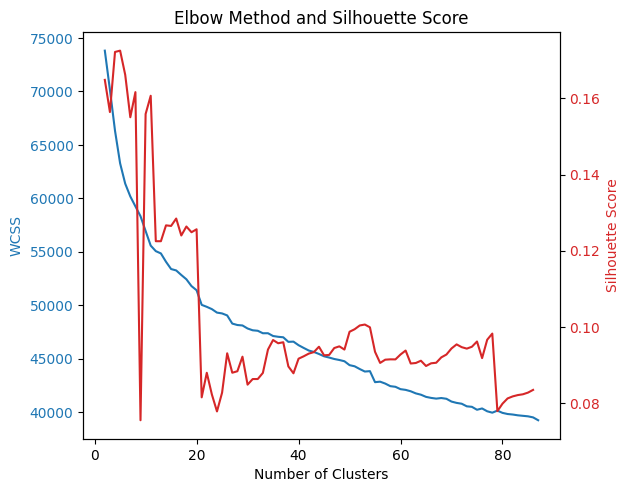

In [ ]:
# Plot the Elbow Method curve and Silhouette Score on the same plot
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS', color=color)
ax1.plot(range(2, 87 + 1), wcss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(range(2, 86 + 1), silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Elbow Method and Silhouette Score')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters= 750, init='k-means++', n_init='auto', random_state=42)
cluster_labels = kmeans.fit_predict(binary_data)
print(kmeans.inertia_)
silhouette_avg = silhouette_score(binary_data, cluster_labels)
print(silhouette_avg)

19818.439924723712
0.21717436110963567


In [ ]:
cluster_centers = torch.tensor(kmeans.cluster_centers_)
cluster_centers.shape

torch.Size([750, 10000])

In [ ]:
cluster_centers[0][:200]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=torch.float64)

In [ ]:
KDE(mals[:100], cluster_centers, 0.6)

In [ ]:
KDE(bens[:100], cluster_centers, 0.6)

NameError: name 'KDE' is not defined